### Llegando a la recta final armo todo en un solo notebook

##### celdas copiadas del treecorr_correlation.ipynb

In [ ]:
import numpy as np
import pandas as pd
import healpy as hp
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from numpy.polynomial.polynomial import Polynomial

def build_cdf_from_parabola(data, vmin, vmax, num_points=10000):
    # Create a histogram of the redshifts
    hist, bin_edges = np.histogram(data, bins=50, range=(vmin, vmax), density=True)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    
    # Fit a parabola (second-degree polynomial) to the histogram
    poly = Polynomial.fit(bin_centers, hist, deg=2)
    z_vals = np.linspace(vmin, vmax, num_points)
    pdf_vals = poly(z_vals)

    # Ensure the PDF is positive and normalized
    pdf_vals = np.clip(pdf_vals, a_min=0, a_max=None)
    pdf_vals /= np.trapz(pdf_vals, z_vals)  # Normalize the PDF

    # Build the CDF
    cdf_vals = np.cumsum(pdf_vals) * (z_vals[1] - z_vals[0])
    cdf_vals /= cdf_vals[-1]  # Normalize to [0, 1]

    # Create inverse CDF via interpolation
    cdf_inv = interp1d(cdf_vals, z_vals, bounds_error=False, fill_value=(vmin, vmax))
    return cdf_inv, z_vals, pdf_vals, cdf_vals

sample = 'All'
 
# Load galaxy data
zmin, zmax = 0.05, 0.15
#cat_sdss = pd.read_csv('../data/MGS_DR7_lpereyra.csv')
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]
cat_sdss = cat_sdss[cat_sdss['mag_abs_r']<-20.5]
if sample=='Fil': cat_sdss = cat_sdss[cat_sdss['dist_fil']<5.]
elif sample=='NonFil': cat_sdss = cat_sdss[cat_sdss['dist_fil']>8.]

ra = cat_sdss['ra'].values  # Right Ascension
dec = cat_sdss['dec'].values  # Declination

# Set the resolution (nside)
nside = 128  # Approx 55 arcmin resolution (adjust as needed)
nrand = 3 # Times the size of the data (around 10% is left after mask)

# Total number of pixels in the map
npix = hp.nside2npix(nside)

# Initialize a mask array (1 = valid, 0 = invalid)
mask = np.zeros(npix, dtype=int)

# Convert RA, Dec to Healpix indices
theta = np.radians(90 - dec)  # Declination to colatitude
phi = np.radians(ra)          # Right Ascension to longitude
pixels = hp.ang2pix(nside, theta, phi)

# Mark these pixels as valid
mask[pixels] = 1

num_randoms = int(10e6)  # Number of random points

# Generate uniform random RA, Dec
ra_random = np.random.uniform(0, 360, num_randoms)  # RA: 0 to 360 degrees
u = np.random.uniform(-1, 1, num_randoms)
dec_random_rad = np.arcsin(u)
dec_random = np.rad2deg(dec_random_rad)
#dec_random = np.random.uniform(-90, 90, num_randoms)  # Dec: -90 to 90 degrees

# Convert RA, Dec to Healpix indices
theta_random = np.radians(90 - dec_random)
phi_random = np.radians(ra_random)
random_pixels = hp.ang2pix(nside, theta_random, phi_random)

# Apply the mask
valid_indices = mask[random_pixels] == 1
ra_random = ra_random[valid_indices]
dec_random = dec_random[valid_indices]

# Read redshift distribution and apply to randoms
# Build the inverse CDF from a smoothed KDE fit
cdf_inv_z, z_vals, pdf_vals, cdf_vals = build_cdf_from_parabola(cat_sdss['red'], zmin, zmax)

# Generate random redshifts
u = np.random.uniform(0, 1, len(ra_random))
red_random = cdf_inv_z(u)

random_data = pd.DataFrame({
    'ra': ra_random[:len(ra)*nrand],
    'dec': dec_random[:len(ra)*nrand],
    'red': red_random[:len(ra)*nrand]
})

print(len(ra))
print(len(random_data))

157285
471855


In [43]:
######################
minsep = 10.      # Min theta
maxsep = 150.      # Max theta
nbins = 30        # Bins in theta
nbootstrap = 10  # No. of bootstrap resampling
brute = False     # Brute force for TreeCorr
npatch = 10

config = {"min_sep": minsep, \
          "max_sep": maxsep, \
            "nbins": nbins, \
            #"sep_units": 'degree', \
            "bin_type": 'Log', \
            #"brute": brute, \
            #"metric": 'Arc', \
            #"var_method": 'bootstrap', \
            #"num_bootstrap": nbootstrap,\
            }
######################

import numpy as np
import pandas as pd
import treecorr
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.74, Om0=0.3089)

def H(ra, dec, z):

  ra  = np.array(ra,  dtype=np.float32) 
  dec = np.array(dec, dtype=np.float32) 
  z   = np.array(z,   dtype=np.float32) 

  r = np.float32(cosmo.comoving_distance(z).value)
  x = r*np.cos(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  y = r*np.sin(np.deg2rad(ra))*np.cos(np.deg2rad(dec))
  z = r*np.sin(np.deg2rad(dec))
  return x, y, z

# Read Gxs
zmin, zmax = 0.05, 0.15
#cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
#cat_sdss = pd.read_csv('../data/MGS_DR7_lpereyra.csv')
cat_sdss = pd.read_csv('../data/sdss_zmin_0.000_zmax_0.300_sigma_5.0.csv')
cat_sdss  = cat_sdss[(cat_sdss["red"] > zmin)*(cat_sdss["red"] < zmax)]
cat_sdss = cat_sdss[cat_sdss['mag_abs_r']<-20.5]
cat_sdss = cat_sdss[cat_sdss['dist_fil']>8.]


In [45]:


# Read Randoms
#cat_random = pd.read_csv('../data/random_sample_healpy_128_561286.csv')
cat_random = random_data

# Transform to Cartesian
cat_random["x"], cat_random["y"], cat_random["z"] = H(cat_random["ra"], cat_random["dec"], cat_random["red"])
cat_sdss["x"], cat_sdss["y"], cat_sdss["z"] = H(cat_sdss["ra"], cat_sdss["dec"], cat_sdss["red"])


# TreeCorr Catalogues
dd = treecorr.NNCorrelation(config)
dr = treecorr.NNCorrelation(config)
rr = treecorr.NNCorrelation(config)
#rd = treecorr.NNCorrelation(config)

rcat = treecorr.Catalog(x=cat_random['x'], y=cat_random['y'], z=cat_random['z'])#, \
                    #npatch=npatch)

gcat = treecorr.Catalog(x=cat_sdss['x'], y=cat_sdss['y'], z=cat_sdss['z'])#, \
                    #npatch=npatch)

dd.process(gcat)
rr.process(rcat)
dr.process(gcat,rcat)

xi, varxi = dd.calculateXi(rr=rr,dr=dr)
th = dd.meanr


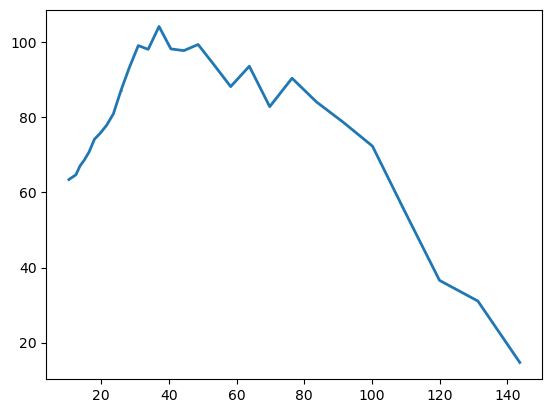

In [46]:
import matplotlib.pyplot as plt
sig = np.sqrt(varxi)

th = dd.meanr

#plt.plot(th, xi, color='C00')
#plt.yscale('log')
#plt.xscale('log')
#plt.plot(th, -xi, color='blue', ls=':')
#plt.errorbar(th[xi>0], xi[xi>0], yerr=sig[xi>0], color='blue', lw=1)
plt.errorbar(th, xi*th**2, yerr=sig, color='C00', lw=2)

#plt.errorbar(th[xi<0], -xi[xi<0], yerr=sig[xi<0], color='blue', lw=0.1, ls='')
#leg = plt.errorbar(-th, xi, yerr=sig, color='blue')

plt.show()